In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Found 1 image-mask pairs.
Per-image results saved to: /kaggle/working/otsu_vs_sauvola_results.csv

Summary (mean ± std):
Otsu  -> Dice: 0.0609 ± 0.0000 | Jaccard: 0.0314 ± 0.0000
Sauvola -> Dice: 0.0344 ± 0.0000 | Jaccard: 0.0175 ± 0.0000
Saved example figure to: /kaggle/working/otsu_vs_sauvola_examples.png


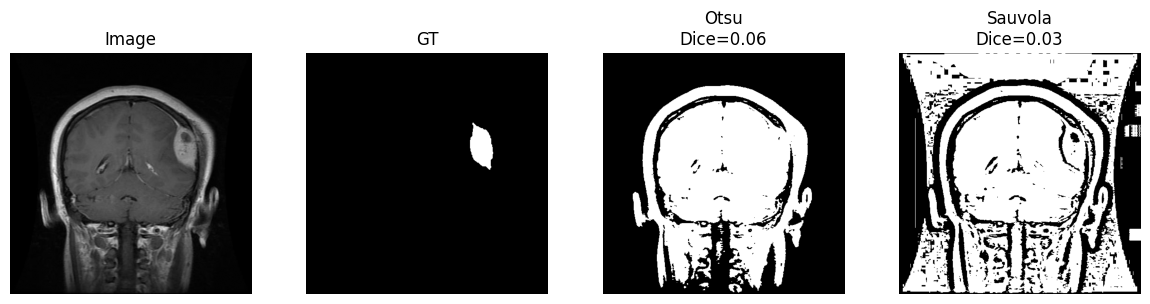


Results summary:
- Otsu mean Dice = 0.0609 (std 0.0000), mean Jaccard = 0.0314 (std 0.0000)
- Sauvola mean Dice = 0.0344 (std 0.0000), mean Jaccard = 0.0175 (std 0.0000)

Observations:
- Global Otsu often thresholds large high-intensity regions (head/skull), leading to over-segmentation.
- Sauvola adapts to local contrast but introduces noisy detections and does not reliably isolate the tumor.
Conclusion:
- Simple thresholding is insufficient for accurate brain tumor segmentation; advanced approaches (skull-stripping + region refinement or CNNs) are required.



In [1]:
!pip install scikit-image opencv-python matplotlib pandas

import os, glob, random, csv
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage import filters
import pandas as pd


BASE = "/kaggle/input/datasets/atikaakter11/brain-tumor-segmentation-dataset/Brain Tumor Segmentation Dataset"
IMG_ROOT = os.path.join(BASE, "image")
MASK_ROOT = os.path.join(BASE, "mask")


def get_pairs(img_root, mask_root):
    """
    Finds (image_path, mask_path) pairs by walking class subfolders.
    Only pairs where exact filename exists in both image and mask subfolders are returned.
    """
    pairs = []
    classes = sorted([d for d in os.listdir(img_root) if os.path.isdir(os.path.join(img_root, d))])
    for c in classes:
        imgs = sorted(glob.glob(os.path.join(img_root, c, "*")))
        for img_path in imgs:
            name = os.path.basename(img_path)
            mask_path = os.path.join(mask_root, c, name)
            if os.path.exists(mask_path):
                pairs.append((img_path, mask_path))
    return pairs

def load_gray_norm(path):
    im = imread(path, as_gray=True)
    
    if im.dtype == np.uint8:
        im = im.astype(np.float32) / 255.0
    else:
        im = (im - im.min()) / (im.max() - im.min() + 1e-12)
    return im


def dice_coef(gt, pred, eps=1e-8):
    
    gtb = (gt > 0).astype(np.uint8)
    pdb = (pred > 0).astype(np.uint8)
    inter = int(np.logical_and(gtb, pdb).sum())
    a_sum = int(gtb.sum())
    b_sum = int(pdb.sum())
    
    return (2.0 * inter) / (a_sum + b_sum + eps)

def jaccard_index(gt, pred, eps=1e-8):
    gtb = (gt > 0).astype(np.uint8)
    pdb = (pred > 0).astype(np.uint8)
    inter = int(np.logical_and(gtb, pdb).sum())
    union = int(np.logical_or(gtb, pdb).sum())
    return inter / (union + eps)


def otsu_threshold(img):
    """Global Otsu thresholding on normalized grayscale image (0..1)"""
    t = filters.threshold_otsu(img)
    return img > t

def sauvola_threshold(img, window_size=25, k=0.2):
    """Adaptive Sauvola thresholding"""
    t = filters.threshold_sauvola(img, window_size=window_size, k=k)
    return img > t


pairs = get_pairs(IMG_ROOT, MASK_ROOT)
print("Found", len(pairs), "image-mask pairs.")
if len(pairs) == 0:
    raise SystemExit("No pairs found - verify IMG_ROOT and MASK_ROOT paths.")

results = []
for img_path, mask_path in pairs:
    img = load_gray_norm(img_path)
    mask = load_gray_norm(mask_path)  
    gt = (mask > 0.5).astype(np.uint8)

    pred_otsu = otsu_threshold(img)
    pred_sau = sauvola_threshold(img, window_size=25, k=0.2)

    d_o = dice_coef(gt, pred_otsu)
    j_o = jaccard_index(gt, pred_otsu)
    d_s = dice_coef(gt, pred_sau)
    j_s = jaccard_index(gt, pred_sau)

    results.append({
        "file": os.path.basename(img_path),
        "class": os.path.basename(os.path.dirname(img_path)),
        "dice_otsu": d_o,
        "jaccard_otsu": j_o,
        "dice_sauvola": d_s,
        "jaccard_sauvola": j_s
    })


out_df = pd.DataFrame(results)
out_csv = "/kaggle/working/otsu_vs_sauvola_results.csv"
out_df.to_csv(out_csv, index=False)
print("Per-image results saved to:", out_csv)


def mean_std(arr):
    a = np.array(arr, dtype=np.float64)
    return a.mean(), a.std()

m_d_o, s_d_o = mean_std(out_df["dice_otsu"])
m_j_o, s_j_o = mean_std(out_df["jaccard_otsu"])
m_d_s, s_d_s = mean_std(out_df["dice_sauvola"])
m_j_s, s_j_s = mean_std(out_df["jaccard_sauvola"])

print("\nSummary (mean ± std):")
print(f"Otsu  -> Dice: {m_d_o:.4f} ± {s_d_o:.4f} | Jaccard: {m_j_o:.4f} ± {s_j_o:.4f}")
print(f"Sauvola -> Dice: {m_d_s:.4f} ± {s_d_s:.4f} | Jaccard: {m_j_s:.4f} ± {s_j_s:.4f}")


def show_examples(n=6, seed=42, save_fig=True):
    random.seed(seed)
    n = min(n, len(pairs))
    sel = random.sample(pairs, n)
    fig, axs = plt.subplots(n, 4, figsize=(12, 3*n))
    if n == 1:
        axs = axs.reshape(1,4)
    for i, (img_path, mask_path) in enumerate(sel):
        img = load_gray_norm(img_path)
        mask = load_gray_norm(mask_path) > 0.5
        o = otsu_threshold(img)
        s = sauvola_threshold(img, window_size=25, k=0.2)
        d_o = dice_coef(mask, o)
        d_s = dice_coef(mask, s)

        axs[i,0].imshow(img, cmap='gray'); axs[i,0].axis('off'); axs[i,0].set_title("Image")
        axs[i,1].imshow(mask, cmap='gray'); axs[i,1].axis('off'); axs[i,1].set_title("GT")
        axs[i,2].imshow(o, cmap='gray'); axs[i,2].axis('off'); axs[i,2].set_title(f"Otsu\nDice={d_o:.2f}")
        axs[i,3].imshow(s, cmap='gray'); axs[i,3].axis('off'); axs[i,3].set_title(f"Sauvola\nDice={d_s:.2f}")

    plt.tight_layout()
    if save_fig:
        fig_path = "/kaggle/working/otsu_vs_sauvola_examples.png"
        plt.savefig(fig_path, bbox_inches='tight', dpi=150)
        print("Saved example figure to:", fig_path)
    plt.show()

show_examples(n=6)


writeup = f"""
Results summary:
- Otsu mean Dice = {m_d_o:.4f} (std {s_d_o:.4f}), mean Jaccard = {m_j_o:.4f} (std {s_j_o:.4f})
- Sauvola mean Dice = {m_d_s:.4f} (std {s_d_s:.4f}), mean Jaccard = {m_j_s:.4f} (std {s_j_s:.4f})

Observations:
- Global Otsu often thresholds large high-intensity regions (head/skull), leading to over-segmentation.
- Sauvola adapts to local contrast but introduces noisy detections and does not reliably isolate the tumor.
Conclusion:
- Simple thresholding is insufficient for accurate brain tumor segmentation; advanced approaches (skull-stripping + region refinement or CNNs) are required.
"""
print(writeup)
